<a href="https://colab.research.google.com/github/seetaram-oruganti/Credit-Card-Fraud-detection/blob/main/MLP_without_outliers_and_with_data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Exploratory data analysis***

In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import imblearn
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [61]:
df.shape

(284807, 31)

In [62]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [63]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [64]:
#Splitting genuine and fraud transactions
df_fraud=df[df['Class']==1]
df_non_fraud=df[df['Class']==0]

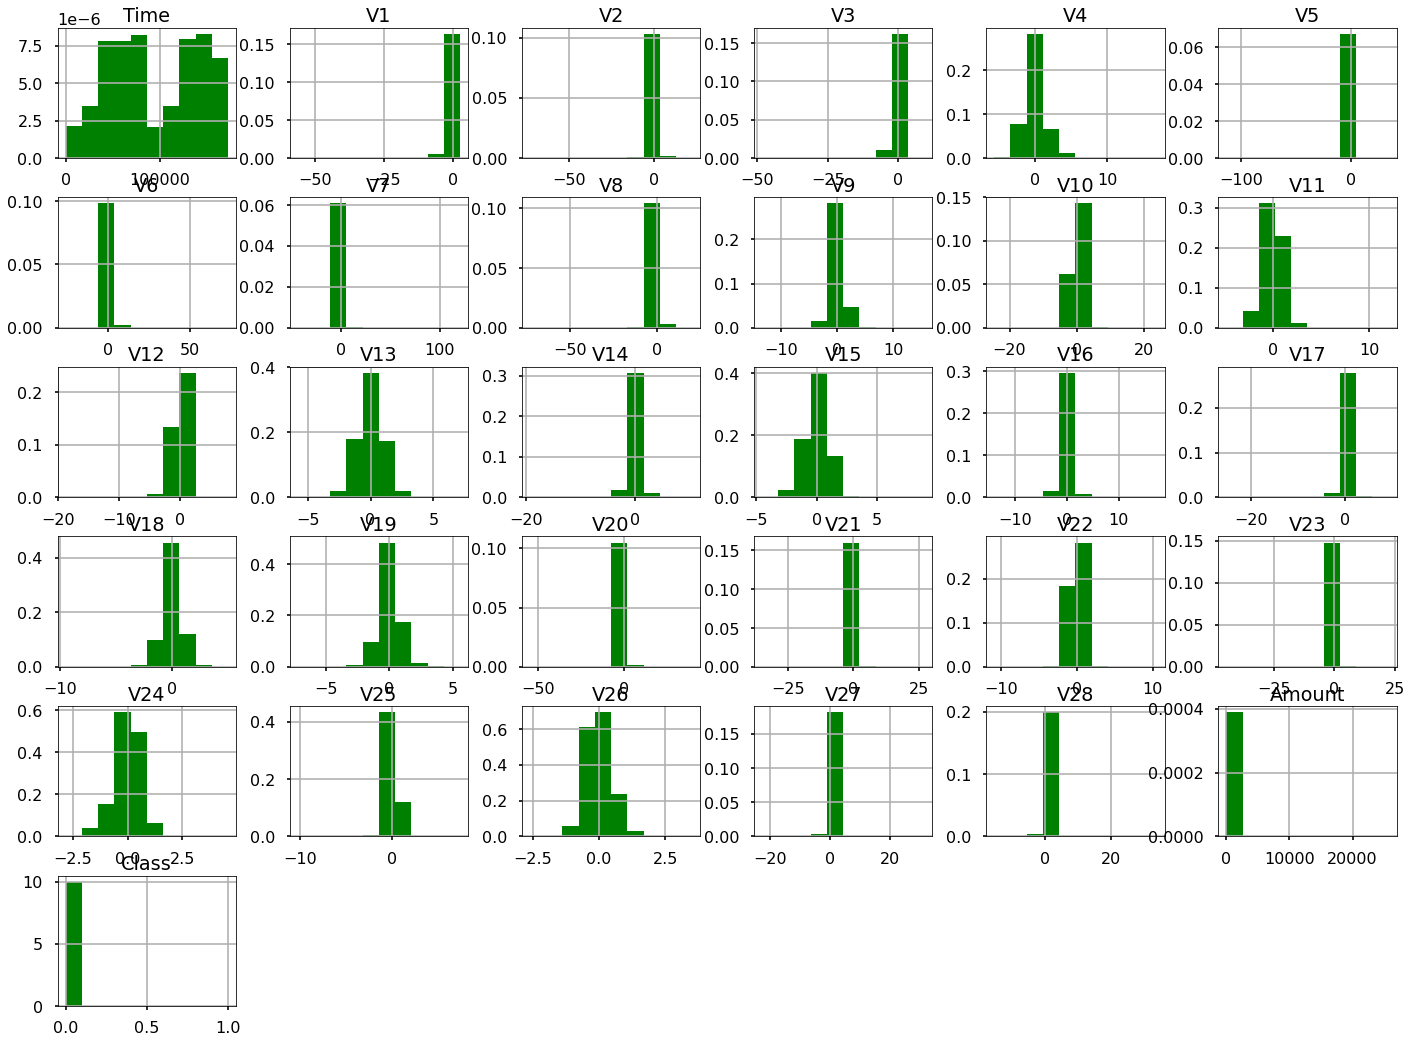

In [65]:
plt.style.use("seaborn-poster")
df.hist(figsize=(24,18),density=True,color="green")
plt.show()

In [66]:
df_fraud.shape

(492, 31)

In [67]:
df_non_fraud.shape

(284315, 31)

Function to remove outliers

In [68]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


# Removing Outliers 
for i in range (1,29):
  name = 'V'+ "%s" %i
  df3=remove_outlier(df,name)


In [69]:
#Splitting genuine and fraud transactions
df_fraud=df3[df3['Class']==1]
df_non_fraud=df3[df3['Class']==0]

print(df3.shape)
print(df_fraud.shape)
print(df_non_fraud.shape)

(254465, 31)
(220, 31)
(254245, 31)


In [70]:
#Data Balancing
df_non_fraud=df_non_fraud.sample(n = 220)
df_non_fraud.head()
df_non_fraud.shape
df_non_fraud.info()

# New Balanced data set with frand and genuine txns 
dfb=df_non_fraud.append(df_fraud)
dfb.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 139768 to 132673
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    220 non-null    float64
 1   V1      220 non-null    float64
 2   V2      220 non-null    float64
 3   V3      220 non-null    float64
 4   V4      220 non-null    float64
 5   V5      220 non-null    float64
 6   V6      220 non-null    float64
 7   V7      220 non-null    float64
 8   V8      220 non-null    float64
 9   V9      220 non-null    float64
 10  V10     220 non-null    float64
 11  V11     220 non-null    float64
 12  V12     220 non-null    float64
 13  V13     220 non-null    float64
 14  V14     220 non-null    float64
 15  V15     220 non-null    float64
 16  V16     220 non-null    float64
 17  V17     220 non-null    float64
 18  V18     220 non-null    float64
 19  V19     220 non-null    float64
 20  V20     220 non-null    float64
 21  V21     220 non-null    float64

(440, 31)

# ***Models without outliers with balanced dataset***

In [71]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 139768 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    440 non-null    float64
 1   V1      440 non-null    float64
 2   V2      440 non-null    float64
 3   V3      440 non-null    float64
 4   V4      440 non-null    float64
 5   V5      440 non-null    float64
 6   V6      440 non-null    float64
 7   V7      440 non-null    float64
 8   V8      440 non-null    float64
 9   V9      440 non-null    float64
 10  V10     440 non-null    float64
 11  V11     440 non-null    float64
 12  V12     440 non-null    float64
 13  V13     440 non-null    float64
 14  V14     440 non-null    float64
 15  V15     440 non-null    float64
 16  V16     440 non-null    float64
 17  V17     440 non-null    float64
 18  V18     440 non-null    float64
 19  V19     440 non-null    float64
 20  V20     440 non-null    float64
 21  V21     440 non-null    float64

In [72]:
X = dfb.iloc[:, :-1]
y = dfb.iloc[:, -1]
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

In [73]:
X_train.shape

(352, 30)

In [74]:
y_train.shape

(352,)

In [75]:
y_test

228836    0
150663    1
39183     1
108258    1
171562    0
         ..
138824    0
258512    0
264909    0
131879    0
67472     0
Name: Class, Length: 88, dtype: int64

# ***Logistic Regression***

In [76]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)   

LogisticRegression()

In [77]:
print(classifier.intercept_, classifier.coef_)

[-0.00175623] [[-2.12425235e-05 -3.40532466e-01  3.81702611e-01 -7.19399643e-01
   6.12476413e-01 -1.98820756e-01 -1.96886623e-01 -4.97566729e-01
   1.30626120e-02 -3.21155973e-01 -6.32325075e-01  4.82671376e-01
  -7.43184149e-01 -3.28955465e-02 -9.48874305e-01 -3.42895822e-02
  -4.47633493e-01 -6.37248944e-01 -1.94975069e-01  7.78895074e-02
   5.01700353e-02  5.10722769e-02  3.68655509e-02  1.99207866e-02
  -1.62908874e-02 -1.65373053e-02  1.52037486e-02  4.63903568e-02
   7.69063930e-03  1.87395001e-03]]


In [78]:
pred = classifier.predict(X_train)

In [79]:
print ('Accuracy from sk-learn: {}'.format(classifier.score(X_train,y_train)))

Accuracy from sk-learn: 0.9034090909090909


In [80]:
from sklearn.metrics import confusion_matrix

In [81]:
pred_b = classifier.predict(X_test)

In [82]:
report= classification_report(y_test,pred_b)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        45
           1       0.92      0.81      0.86        43

    accuracy                           0.88        88
   macro avg       0.88      0.87      0.87        88
weighted avg       0.88      0.88      0.87        88



In [83]:
import sklearn.metrics as metrics
confusion_matrix = metrics.confusion_matrix(y_test, pred_b)


In [84]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

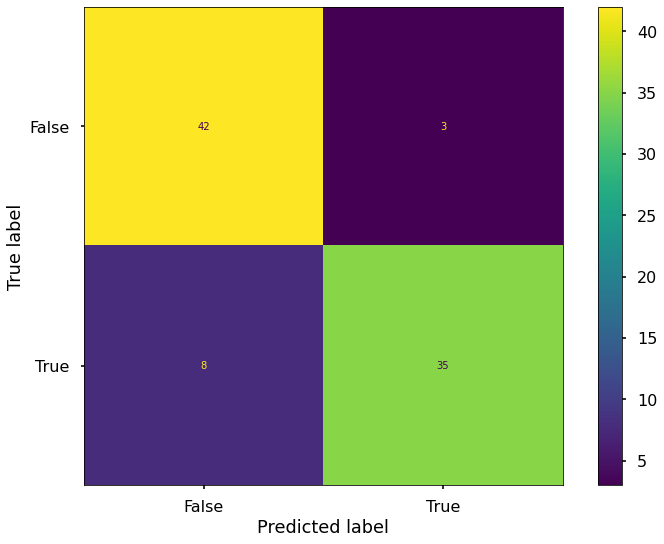

In [85]:
cm_display.plot()
plt.show()

# ***K - Nearest Neighbour***

In [86]:
classifier=KNeighborsClassifier()

In [87]:
classifier.fit(X_train, y_train)   

KNeighborsClassifier()

In [88]:
pred = classifier.predict(X_train)

In [89]:
print ('Accuracy from sk-learn: {}'.format(classifier.score(X_train,y_train)))


Accuracy from sk-learn: 0.7045454545454546


In [90]:
pred_b = classifier.predict(X_test)

In [91]:
report= classification_report(y_test,pred_b)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.51      0.57        45
           1       0.58      0.70      0.63        43

    accuracy                           0.60        88
   macro avg       0.61      0.60      0.60        88
weighted avg       0.61      0.60      0.60        88



In [92]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_b)

In [93]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

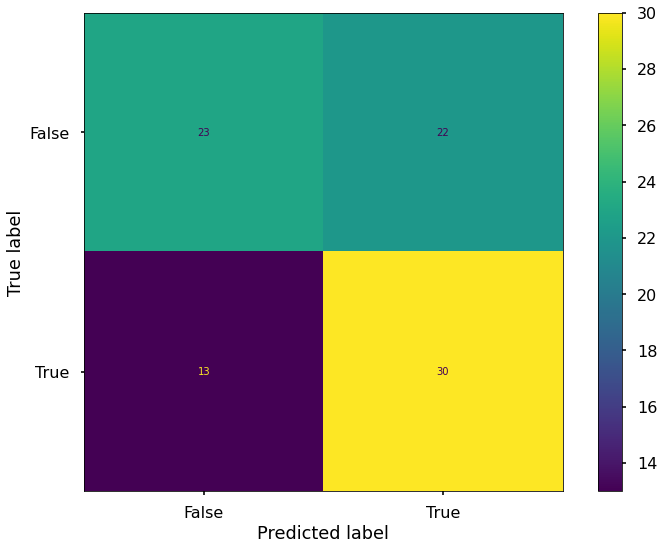

In [94]:
cm_display.plot()
plt.show()

# ***Support Vector Machine***

In [95]:
classifier=SVC()

In [96]:
classifier.fit(X_train, y_train)   

SVC()

In [97]:
pred = classifier.predict(X_train)

In [98]:
print ('Accuracy from sk-learn: {}'.format(classifier.score(X_train,y_train)))

Accuracy from sk-learn: 0.5056818181818182


In [99]:
pred_b = classifier.predict(X_test)

In [100]:
report= classification_report(y_test,pred_b)
print(report)

              precision    recall  f1-score   support

           0       0.46      0.56      0.51        45
           1       0.41      0.33      0.36        43

    accuracy                           0.44        88
   macro avg       0.44      0.44      0.43        88
weighted avg       0.44      0.44      0.44        88



In [101]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_b)

In [102]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

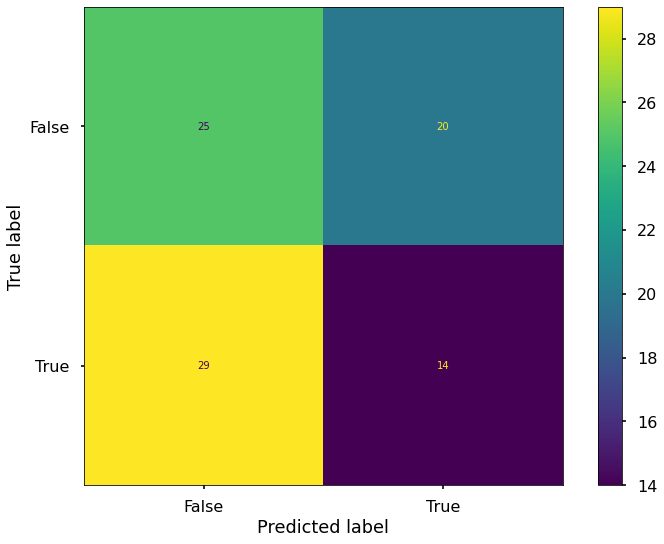

In [103]:
cm_display.plot()
plt.show()

# **Decision Tree Classifier**

In [104]:
classifier=DecisionTreeClassifier()

In [105]:
classifier.fit(X_train, y_train) 

DecisionTreeClassifier()

In [106]:
pred = classifier.predict(X_train)

In [107]:
print ('Accuracy from sk-learn: {}'.format(classifier.score(X_train,y_train)))

Accuracy from sk-learn: 1.0


In [108]:
# print('Accuracy from DecisionTreeClassifier for training : 0.89')

In [109]:
pred_b = classifier.predict(X_test)

In [110]:
report= classification_report(y_test,pred_b)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        45
           1       0.92      0.81      0.86        43

    accuracy                           0.88        88
   macro avg       0.88      0.87      0.87        88
weighted avg       0.88      0.88      0.87        88



In [111]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

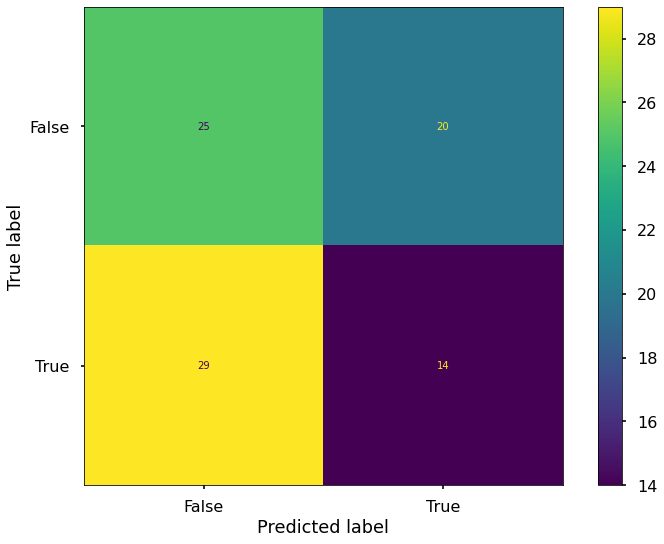

In [112]:
cm_display.plot()
plt.show()